Importation des bibliothèques essentielles

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

Chargement des données

In [2]:
full_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Préparation des Données pour l'Entraînement et la Soumission

In [4]:
# Séparez le test_df PassengerId (il en aura besoin pour la soumission)
test_pass_id = test_df.PassengerId.copy()

# Keep max index that will be used to back split training and test data
X_max_index = full_df.shape[0]

# Separate features and target
y = full_df.Transported.astype(int)

df = full_df.drop(['Transported'], axis=1).copy()
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


Visualisation de la Distribution des Caractéristiques avec des Histogrammes

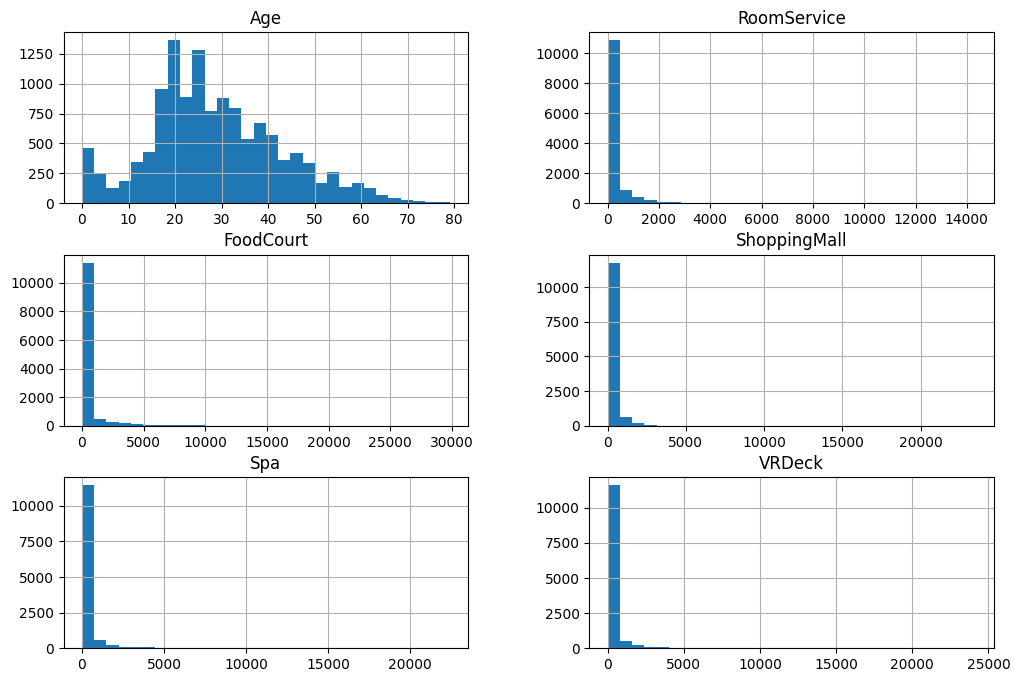

In [5]:
df.hist(bins=30, figsize=(12, 8))
plt.show()

Création de Nouvelles Caractéristiques à partir des Colonnes Existantes

In [6]:
# Split passenger group into separate feature
df['Pass_group'] = df.PassengerId.str.split('_').str[0]
df.Pass_group = df.Pass_group.astype(float)

# Split Lastname into separate feature
df['Lastname'] = df.Name.str.split(' ').str[1]

# Split Cabin into 3 separate features
df[['Deck', 'Cab_num', 'Deck_side']] = df.Cabin.str.split('/', expand=True)
df.Cab_num = df.Cab_num.astype(float)

Identification des Outliers à l'aide de Graphiques de Dispersion

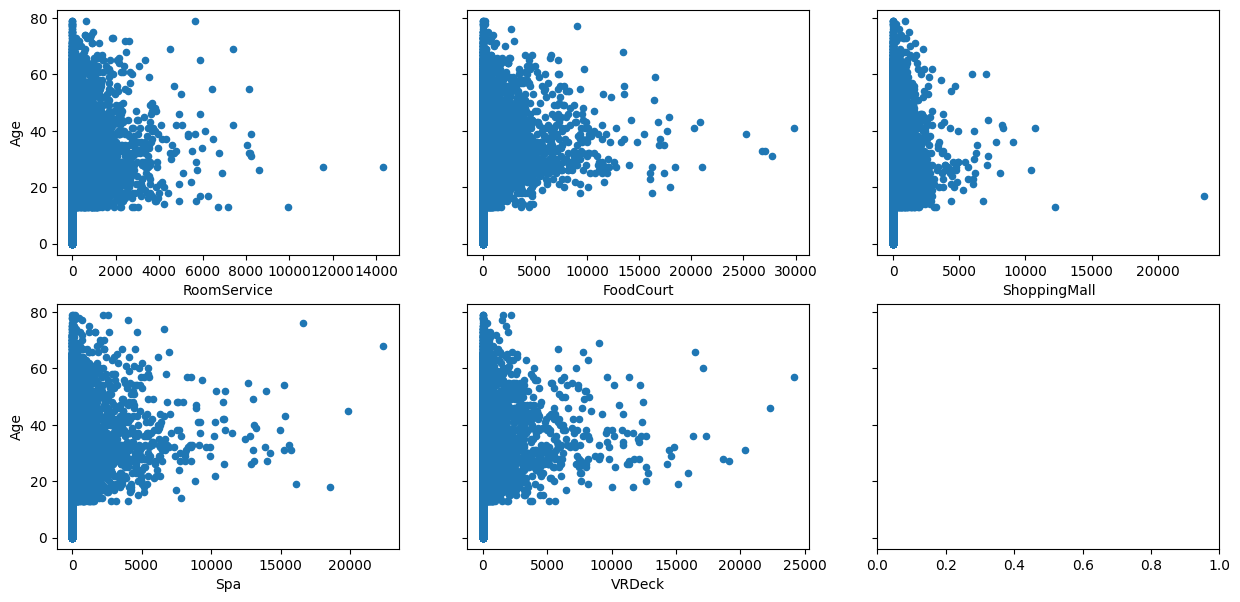

In [7]:
# Looking for outliers
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

Traitement des Outliers : Application d'un Seuil Maximum (Capping) sur les Variables

In [8]:
# Cap RoomService at 9000
df.loc[df.RoomService.gt(9000), 'RoomService'] = 9000

# Cap FoodCourt at 22000
df.loc[df.FoodCourt.gt(22000), 'FoodCourt'] = 22000

# Cap ShoppingMall at 11000
df.loc[df.ShoppingMall.gt(11000), 'ShoppingMall'] = 11000

# Cap Spa at 17000
df.loc[df.Spa.gt(17000), 'Spa'] = 17000

# Cap VRDeck at 21000
df.loc[df.VRDeck.gt(21000), 'VRDeck'] = 21000

# Run previous cell again to visualize the result

Traitement des Outliers : Application d'un Seuil Maximum (Capping) sur les Variables

In [9]:
# Check if the passengers in CryoSleep have always zero values for amenities
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df.loc[df.CryoSleep.eq(True), amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

Imputation des Valeurs Manquantes dans les Variables d'Amenities

In [10]:
# For passengers in CryoSleep we impute zero for missing amenities values
df.loc[df.CryoSleep.eq(True), amenities] = 0

# Where summ of amenities is 0 we also impute 0 for missing values
zero_amenities = df[amenities].sum(axis=1).eq(0)
df.loc[zero_amenities, amenities] = 0

# Impute median for values greater than 0 for each amenities column where passengers are not in CryoSleep
for i in amenities:
    df.loc[df[i].isna(), i] = df.loc[df[i].gt(0), i].median()

Calcul des Dépenses Totales sur les Amenities

In [11]:
# We will calculate the total expenses the passenger had on amenities
df['Total_expenses'] = df[amenities].sum(axis=1)

In [12]:
# Impute CryoSleep = False where Total_expenses are greater than 0
df.loc[(df.CryoSleep.isna() & df.Total_expenses.gt(0)), 'CryoSleep'] = False

Vérification de l'Âge Minimum des Passagers avec Statut VIP

In [13]:
# Check the minimum Age for passengers with VIP status
df.groupby('VIP').Age.min()

VIP
False     0.0
True     18.0
Name: Age, dtype: float64

Analyse des Passagers VIP par Planète d'Origine et Destination

In [14]:
# Check VIPs by HomePlanet and Destination
df.groupby(['HomePlanet', 'Destination']).VIP.value_counts()

HomePlanet  Destination    VIP  
Earth       55 Cancri e    False     956
            PSO J318.5-22  False    1043
            TRAPPIST-1e    False    4568
Europa      55 Cancri e    False    1195
                           True       83
            PSO J318.5-22  False      16
                           True       13
            TRAPPIST-1e    False    1618
                           True       78
Mars        55 Cancri e    False     290
            PSO J318.5-22  False      55
                           True        9
            TRAPPIST-1e    False    2122
                           True       81
Name: count, dtype: int64

In [15]:
# Impute VIP = False for underage passengers
df.loc[(df.VIP.isna() & (df.Age < 18)), 'VIP'] = False

In [16]:
# Impute VIP = False for passengers from Earth
df.loc[(df.VIP.isna() & (df.HomePlanet == 'Earth')), 'VIP'] = False

# Impute VIP = False for passengers from Mars that goes to Cancri
df.loc[(df.VIP.isna()
        & (df.HomePlanet.eq('Mars'))
        & (df.Destination.eq('55 Cancri e'))), 'VIP'] = False

Analyse des Passagers VIP et CryoSleep par Pont

In [17]:
# Check VIPs and CryoSleep by Deck
df.groupby(['VIP', 'CryoSleep']).Deck.value_counts()

VIP    CryoSleep  Deck
False  False      F       3309
                  G       1701
                  E       1023
                  C        561
                  D        500
                  B        464
                  A        204
                  T         10
       True       G       2018
                  F        837
                  B        581
                  C        442
                  E        249
                  D        164
                  A         92
True   False      B         48
                  C         45
                  F         41
                  A         40
                  D         38
                  E         26
       True       B         10
                  C         10
                  A          5
                  D          3
Name: count, dtype: int64

In [18]:
# Impute VIP = False for passengers on deck G and T
df.loc[(df.VIP.isna()
        & (df.Deck.isin(['G', 'T']))), 'VIP'] = False

# Impute VIP = True for passengers that are not on decks A to D and not in CryoSleep
df.loc[df.VIP.isna()
       & df.CryoSleep.eq(False)
       & ~df.Deck.isin(['A', 'B', 'C', 'D']), 'VIP'] = True

In [19]:
# From previous analysis VIPs going to Cancri are just from Europa
df.loc[(df.HomePlanet.isna()
        & df.VIP.eq(True)
        & df.Destination.eq('55 Cancri e')), 'HomePlanet'] = 'Europa'

In [20]:
# Check if all the passengers from the same group have departed from the same HomePlanet
df.groupby('Pass_group').HomePlanet.nunique().gt(1).sum()

0

In [21]:
# Create a Pass_group-HomePlanet dictionary
present_values = ~df.Pass_group.isna() & ~df.HomePlanet.isna()
group_home_map = (df.loc[present_values, ['Pass_group', 'HomePlanet']]
            .set_index('Pass_group').to_dict()['HomePlanet'])

# Impute HomePlanet from dictionary
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Pass_group.map(group_home_map)

In [22]:
# Analyse HomePlanet-Deck distribution
df.groupby('HomePlanet').Deck.value_counts

<bound method SeriesGroupBy.value_counts of <pandas.core.groupby.generic.SeriesGroupBy object at 0x000002016EF35BD0>>

In [23]:
# Impute HomePlanet based on previous distribution analysis
df.loc[(df.HomePlanet.isna()
        & df.Deck.isin(['T', 'A', 'B', 'C',])), 'HomePlanet'] = 'Europa'

df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

In [24]:
# Check if all the passengers with the same Lastname have departed from the same HomePlanet
df.groupby('Lastname').HomePlanet.nunique().gt(1).sum()

1

In [25]:
# Create a Lastname-HomePlanet dictionary
present_values = ~df.Lastname.isna() & ~df.HomePlanet.isna()
lastname_home_map = (df.loc[present_values, ['Lastname', 'HomePlanet']]
            .set_index('Lastname').to_dict()['HomePlanet'])

# Impute HomePlanet from dictionary
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Lastname.map(lastname_home_map)

In [26]:
# Impute median Age for people with VIP status
df.loc[((df['VIP'] == True) & df['Age'].isna()), 'Age'] = df.loc[(df['VIP'] == True), 'Age'].median()

# Impute median Age for people that have expenses
df.loc[(df['Age'].isna() & df['Total_expenses'].gt(0)), 'Age'] = df.loc[df['Total_expenses'].gt(0), 'Age'].median()

# Impute median Age for people with no expenses and not in CryoSleep
df.loc[(df['Age'].isna() & df['Total_expenses'].eq(0) & df['CryoSleep'].eq(False)), 'Age'] = \
    df.loc[(df['Total_expenses'].eq(0) & df['CryoSleep'].eq(False)), 'Age'].median()

# Impute an overall median Age for people not included in previous groups
df['Age'] = df['Age'].fillna(df['Age'].median())

In [27]:
df['Cab_num'] = df['Cab_num'].fillna(df['Cab_num'].median())

In [28]:
# We count the number of passengers in each group
Group_members = df.Pass_group.value_counts().to_dict()
df['Group_members'] = df.Pass_group.map(Group_members)

In [29]:
# We count the number of members in each cabin
Cabin_members = df['Cabin'].value_counts().to_dict()
df['Cabin_members'] = df['Cabin'].map(Cabin_members)

# Impute mean for missing cabin members (corrigé)
df['Cabin_members'] = df['Cabin_members'].fillna(df['Cabin_members'].mean())


In [30]:
# Create full data frame for analysis
X = df[:X_max_index]
test_df = df[X_max_index:]
full_df = pd.concat([X, y], axis=1).copy()

# Total passengers by Deck
deck_total_pass = full_df.groupby('Deck')['Deck'].count()

# Total Transported by Deck
deck_total_transported = full_df.groupby('Deck')['Transported'].sum()

# Dictionary with Deck_transp_ratio
Deck_transp_ratio = (deck_total_transported / deck_total_pass).to_dict()

# Create Deck_transp_ratio
df['Deck_transp_ratio'] = df['Deck'].map(Deck_transp_ratio)

# Impute mean for missing values (corrigé)
df['Deck_transp_ratio'] = df['Deck_transp_ratio'].fillna(df['Deck_transp_ratio'].mean())

In [31]:
# Total passengers by Deck_side
deck_side_total = full_df.groupby('Deck_side')['Deck'].count()

# Total Transported by Deck_side
deck_side_transported = full_df.groupby('Deck_side')['Transported'].sum()

# Dictionary with Deck_side_transp_ratio
Deck_side_transp_ratio = (deck_side_transported / deck_side_total).to_dict()

# Create Deck_side_transp_ratio
df['Deck_side_transp_ratio'] = df['Deck_side'].map(Deck_side_transp_ratio)

# Impute mean for missing values (corrigé)
df['Deck_side_transp_ratio'] = df['Deck_side_transp_ratio'].fillna(df['Deck_side_transp_ratio'].mean())

In [32]:
# Drop further unused columns
col_drop = ['PassengerId', 'Cabin', 'Name', 'Lastname']
df = df.drop(col_drop, axis=1)

In [33]:
# List of categorical columns
categ_cols = list(df.select_dtypes(['object', 'category']).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]),
                      columns=df[categ_cols].columns)

# Encode categoricals
df_cat = pd.get_dummies(df_cat)

In [34]:
# List of numerical columns
num_cols = list(df.select_dtypes(['int64', 'float64']).columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df[num_cols]], axis=1)

# Impute numericals
it_imp = IterativeImputer()
df = pd.DataFrame(it_imp.fit_transform(df), columns=df.columns)

In [35]:
# Create a full data frame for analysis
X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)
full_df['Non_zero_expenses'] = full_df.loc[full_df.Total_expenses.gt(0), 'Total_expenses']

In [36]:
# Function for kde plotting
def transported_chance_by(feature, xticks=None, xlim=None):
    transported = full_df[full_df.Transported == 1]
    not_transported = full_df[full_df.Transported == 0]

    plt.figure(figsize=(10, 5))

    transported[feature].plot(kind='kde', label='transported')
    not_transported[feature].plot(kind='kde', label='not_transported')

    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

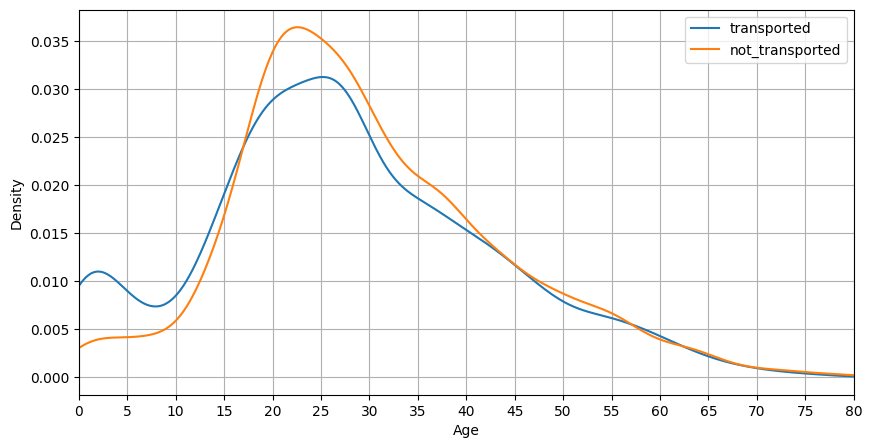

In [37]:
# Transported by Age
transported_chance_by('Age', np.arange(0, 81, 5), (0, 80))

In [38]:
# Create Age_group feature
df['Age_group'] = pd.cut(x=df.Age, labels=[1, 3, 2],
                         bins=[-1, 17, 43, df.Age.max()]).astype('float')

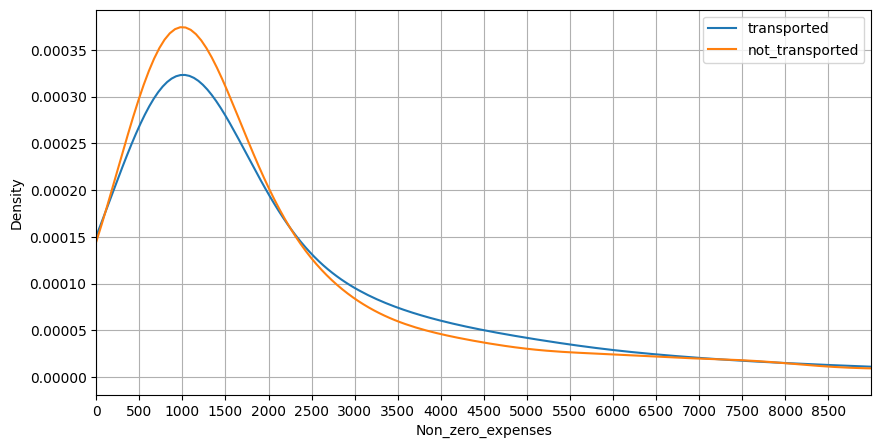

In [39]:
# Transported by Non_zero_expenses
transported_chance_by('Non_zero_expenses', np.arange(0, 9000, 500), (0, 9000))

In [40]:
# Create Total_expenses_group feature additionally separating 0 expenses group
df['Total_expenses_group'] = pd.cut(x=df.Total_expenses, labels=[3, 1, 2],
                         bins=[-1, 1, 2250, df.Total_expenses.max()]).astype('float')

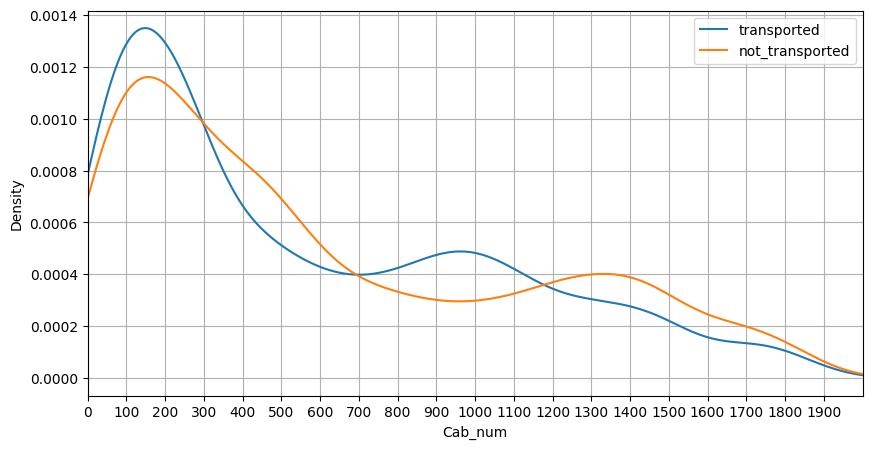

In [41]:
# Transported by Cab_num
transported_chance_by('Cab_num', np.arange(0, 2000, 100), (0, 2000))

In [42]:
# Create Cab_group feature
df['Cab_group'] = pd.cut(x=df.Cab_num, labels=[3, 2, 4, 1],
                         bins=[-1, 300, 690, 1170, df.Cab_num.max()]).astype('float')

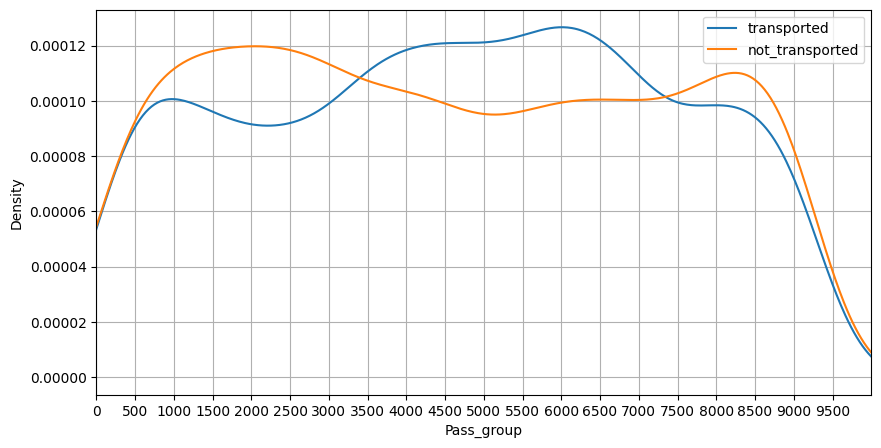

In [43]:
# Transported by Pass_group
transported_chance_by('Pass_group', np.arange(0, 10000, 500), (0, 10000))

In [44]:
# Create Pass_group_type feature
df['Pass_group_type'] = pd.cut(x=df.Pass_group, labels=[2, 3, 1],
                               bins=[-1, 3400, 7300, df.Pass_group.max()]).astype('float')

In [45]:
# Apply np.log to normalize the skewed right data
skewed_features = ['RoomService', 'FoodCourt', 'ShoppingMall',
                   'Spa', 'VRDeck', 'Total_expenses']
df[skewed_features] = df[skewed_features].apply(np.log1p)

# Standardize
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [46]:
# Drop columns not used for modeling
col_drop = ['Cab_num', 'Pass_group']
df = df.drop(col_drop, axis=1)

In [47]:
X = df[:X_max_index]
test_df = df[X_max_index:]

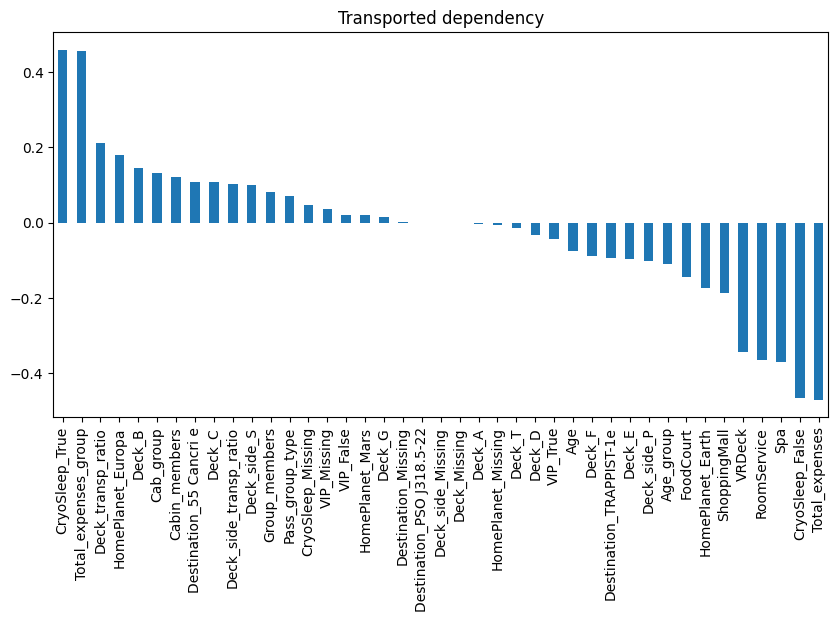

In [48]:
# Concatenate into a full dataset
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Transported'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Transported dependency')
plt.show()

In [49]:
# From Feature selector we've got this list of final features to use
final_features = [
    'HomePlanet_Earth', 'HomePlanet_Mars', 'HomePlanet_Missing', 'CryoSleep_True',
    'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_Missing',
    'Deck_T', 'Deck_side_P', 'Age', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck',
    'Total_expenses', 'Group_members', 'Deck_transp_ratio', 'Total_expenses_group', 'Cab_group']

In [50]:
# Best parameters
params =  {'depth': 6,
           'iterations': 2000,
           'learning_rate': 0.01,
           'thread_count': -1,
           'verbose': False}

In [51]:
# Définir et entraîner le modèle
cat_model = CatBoostClassifier(**params)
cat_model.fit(X[final_features], y)

# Vérifier l'accuracy avec la validation croisée
cat_accuracies = cross_val_score(cat_model, X[final_features], y, cv=5, scoring="accuracy")

# Afficher les résultats
print(pd.Series(cat_accuracies).describe())
accuracy_mean = cat_accuracies.mean() * 100
print(f"Accuracy moyenne du modèle : {accuracy_mean:.2f}%")

# Importance des features
print("\n", cat_model.get_feature_importance(prettified=True))


count    5.000000
mean     0.820432
std      0.019031
min      0.801610
25%      0.808400
50%      0.811386
75%      0.834388
max      0.846375
dtype: float64
Accuracy moyenne du modèle : 82.04%

                    Feature Id  Importances
0           Deck_transp_ratio    14.986643
1                         Spa    11.864934
2              Total_expenses    11.683020
3                      VRDeck    10.314285
4            HomePlanet_Earth     8.320324
5                 RoomService     7.836406
6        Total_expenses_group     6.126846
7                 Deck_side_P     5.458912
8                   Cab_group     5.224130
9                         Age     4.753066
10            HomePlanet_Mars     3.848547
11               ShoppingMall     2.839611
12             CryoSleep_True     2.476837
13    Destination_TRAPPIST-1e     2.051503
14              Group_members     1.414391
15  Destination_PSO J318.5-22     0.342915
16                     Deck_A     0.311524
17               Deck_Missing

In [52]:
# Sauvegarder le modèle entraîné
cat_model.save_model("catboost_model.cbm")


In [53]:
predictions = cat_model.predict(test_df)
print(predictions[:10])  #


[1 0 1 1 1 1 1 1 1 1]


In [54]:
import pandas as pd



data = pd.read_csv("train.csv")
print(data.columns)


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [55]:

train_data = pd.read_csv("train.csv")


print(train_data.columns)


train_data['HomePlanet'] = train_data['HomePlanet'].map({'Earth': 0, 'Mars': 1, 'Venus': 2})
train_data['Destination'] = train_data['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1})


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [56]:
# 
X = train_data[['Age', 'VIP', 'HomePlanet']]  
y = train_data['Transported']


In [57]:
from catboost import CatBoostClassifier

# 
cat_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1)


cat_model.fit(X, y)

import joblib
joblib.dump(cat_model, "catboost_model.pkl")


0:	learn: 0.6867003	total: 6.83ms	remaining: 6.83s


1:	learn: 0.6810411	total: 14.1ms	remaining: 7.05s
2:	learn: 0.6762811	total: 20.6ms	remaining: 6.86s
3:	learn: 0.6732259	total: 24.8ms	remaining: 6.18s
4:	learn: 0.6689405	total: 31.5ms	remaining: 6.28s
5:	learn: 0.6665981	total: 39.8ms	remaining: 6.6s
6:	learn: 0.6649610	total: 44.6ms	remaining: 6.33s
7:	learn: 0.6641473	total: 48.7ms	remaining: 6.04s
8:	learn: 0.6632132	total: 53.7ms	remaining: 5.91s
9:	learn: 0.6621672	total: 58.5ms	remaining: 5.79s
10:	learn: 0.6603164	total: 63.8ms	remaining: 5.74s
11:	learn: 0.6595230	total: 69.3ms	remaining: 5.7s
12:	learn: 0.6584771	total: 75.6ms	remaining: 5.74s
13:	learn: 0.6577630	total: 81.2ms	remaining: 5.72s
14:	learn: 0.6572979	total: 86.5ms	remaining: 5.68s
15:	learn: 0.6565126	total: 92.1ms	remaining: 5.66s
16:	learn: 0.6550102	total: 97.7ms	remaining: 5.65s
17:	learn: 0.6546581	total: 103ms	remaining: 5.61s
18:	learn: 0.6540474	total: 107ms	remaining: 5.55s
19:	learn: 0.6537586	total: 112ms	remaining: 5.51s
20:	learn: 0.6534942	total

['catboost_model.pkl']

In [58]:

cat_model = joblib.load("catboost_model.pkl")

test_data = pd.DataFrame([[30, 1, 0]], columns=["Age", "VIP", "HomePlanet"])


prediction = cat_model.predict(test_data)


print("prediction:", "Transporte" if prediction[0] == 1 else "No Transporte")


prediction: No Transporte


In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Charger le modèle
cat_model = joblib.load("catboost_model.pkl")

# Fonction de prédiction
def predict_survival(age, vip, homeplanet):
    # Vérifier que l'âge est un nombre positif
    if age <= 0:
        return "L'âge doit être un nombre positif."

    # Convertir "Oui" en 1 et "Non" en 0 pour le VIP
    vip = 1 if vip == "Oui" else 0

    # Encoder "HomePlanet" en valeurs numériques
    homeplanet_mapping = {"Earth": 0, "Mars": 1, "Autre": 2}
    homeplanet_encoded = homeplanet_mapping.get(homeplanet, -1)  # Si la valeur est inconnue, -1
    
    if homeplanet_encoded == -1:
        return "Planète d'origine invalide."

    # Créer les données d'entrée
    input_data = pd.DataFrame([[age, vip, homeplanet_encoded]], columns=["Age", "VIP", "HomePlanet"])
    
    # Faire la prédiction avec le modèle
    prediction = cat_model.predict(input_data)
    
    # Retourner le résultat en fonction de la prédiction
    return "Transporté" if prediction[0] == 1 else "Non Transporté"

# Interface Gradio
interface = gr.Interface(
    fn=predict_survival,
    inputs=[
        gr.Number(label="Âge", value=1),  # Âge sous forme d'entier positif sans step
        gr.Radio(["Oui", "Non"], label="VIP"),  # Choix "Oui" ou "Non" pour VIP
        gr.Dropdown(["Earth", "Mars", "Autre"], label="Planète d'origine")  # Sélectionner la planète d'origine
    ],
    outputs="text",
    title="Prédiction de survie",
    description="Entrez vos informations pour prédire si vous avez survécu ou non."
)

# Lancer l'application
interface.launch()

   



C:\Users\Oussame\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


: 